In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
! pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 12.2 MB/s eta 0:00:00


In [1]:
#%cd /content/gdrive/MyDrive/thesis/predictive-coding-thesis/src

import math
import torch
import matplotlib.pyplot as plt
import numpy as np

import torchvision

from torch.utils.data import TensorDataset, DataLoader, random_split

#from tqdm.autonotebook import tqdm, trange

from utils.models import *
from utils.model_tools import *
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

In [2]:
device = "cuda:1" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

!pwd

Using cuda:1 device
/home/mag/predictive-coding-thesis/src


### Training the Predictive Coder model

In [3]:
# downsampling to 64x64
#%cd /content/gdrive/MyDrive/thesis/predictive-coding-thesis/src

downsample = False

if downsample:
    import cv2
    data_dir = 'data/continuous-valid'
    prefix = 'frames'
    for filename in os.listdir(data_dir):
        if filename.startswith(prefix):
            frames_path = os.path.join(data_dir, filename)
            print(frames_path)
            frames = np.load(frames_path)
            downsampled_images = []

            for frame in frames:
                resized_img = cv2.resize(frame, (64, 64), interpolation=cv2.INTER_AREA)
                downsampled_images.append(resized_img)

            downsampled_stack = np.stack(downsampled_images, axis=0)
            np.save(frames_path, downsampled_stack)


# ok I think I actually messed up with not filtering out some of the repeats or bigger jumps in the data I don't remember
# it might be on eschatron? maybe?

In [4]:
# preprocess data by removing consecutive repeat frames
remove_repeats = False

if remove_repeats:
    from utils.data_processing import remove_consecutive_repeats

    data_dir = 'data/face-forward'
    prefix = 'coords'
    for filename in os.listdir(data_dir):
        if filename.startswith(prefix) and not os.path.isdir(filename):
            file_suffix = filename[len(prefix):]
            coords_path = os.path.join(data_dir, filename)
            frames_path = os.path.join(data_dir, 'frames' + file_suffix)
            #print(coords_path)

            #kept_idx = remove_consecutive_repeats(coords_path)

            coords = np.load(coords_path)
            frames = np.load(frames_path)
            if coords.shape[0] != frames.shape[0]:
                print(frames_path)
                print(coords.shape)
                print(frames.shape)
            #np.save(coords_path, coords[kept_idx])
            #np.save(frames_path, frames[kept_idx])
            print(f'removed {len(coords) - len(kept_idx)} from {filename}')

            del coords
            del frames

In [5]:
torch.manual_seed(321)

# need to consider if you actually want to transform
transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

data_dir = 'data/continuous'

dataset = HeadingDataset(source_directory=data_dir,
                                 transform=transform, num_samples=100000)


train_ratio = math.floor(len(dataset) * 0.9)
train_data, test_data = random_split(dataset, [train_ratio, len(dataset) - train_ratio])
print(f'{train_ratio} training samples')

batch_size = 64
# does it matter in this instance if you shuffle? I think you can get away with it
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

90000 training samples


tensor([106., -10.,  -7., -31.,  50., -18., -23.])


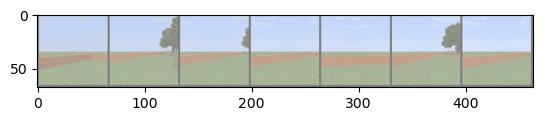

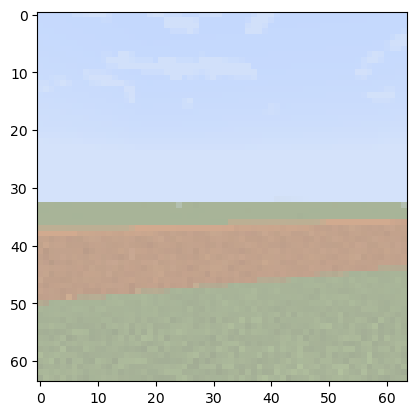

In [6]:
# Take a look at the sequence of images

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

seq, preds = next(iter(train_loader))
frames, headings = seq
print(headings[0])
imshow(torchvision.utils.make_grid(frames[0]))
imshow(preds[0])

In [6]:
model = PredictiveCoderWithHead()
model.to(device)
print(len(train_loader))

num_epochs = 200 # in the actual example this will be 200
steps_per_epoch = len(train_loader) #?

learning_rate = 0.05
weight_decay = 5 * 10**-6

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay, nesterov=True)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, learning_rate, epochs=num_epochs, steps_per_epoch=steps_per_epoch)


1407


In [ ]:
model_file = f'model_files/continous_{train_ratio}_samples-{num_epochs}ep-trainable-hd.pt'
train_losses_file = f'logs/continuous-ep{num_epochs}-train_{train_ratio}-trainable-hd.txt'
test_losses_file = f'logs/continuous-ep{num_epochs}-test_{train_ratio}-trainable-hd.txt'
#model_checkpoint = f'model_files/continous_{train_ratio}_samples-60ep.pth'

train_losses = []
test_losses = []

start_epoch = 0

try:
  # assumes previous checkpoint
  #checkpoint = torch.load(model_checkpoint)

  #model.load_state_dict(checkpoint['state_dict'])
  #optimizer.load_state_dict(checkpoint['optimizer'])
    
  #start_epoch = checkpoint['epoch']
  #test_losses = checkpoint.get('loss_history', [])

  for epoch in range(start_epoch, num_epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    #for param_group in optimizer.param_groups:
    #    param_group['lr'] *= 0.5
    #    lr = param_group['lr']
    #    print(f'learning rate {lr}')
    train_loss = train_heading(train_loader, model, loss_fn, optimizer, device)
    test_loss = test_heading(test_loader, model, loss_fn, device)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    lr_scheduler.step()

    if epoch % 10 == 0:
      state = {
        'epoch': epoch + 1,  # Save next epoch number since current one is completed
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'loss_history': test_losses,
      }

      model_checkpoint = f'model_files/continous_detach_{train_ratio}_samples-{epoch}ep-trainable-hd.pth'
      # Save the state dictionary; adjust the path as necessary
      torch.save(state, model_checkpoint)


finally:
    torch.save(model.state_dict(), model_file)

    with open(train_losses_file, 'w') as fp:
        for s in train_losses:
            fp.write("%s\n" % s)

    with open(test_losses_file, 'w') as fp:
        for x in test_losses:
            fp.write("%s\n" % x)

    print("Done!")

Epoch 1
-------------------------------
loss: 0.138343  [    0/90000]
loss: 0.031510  [ 2000/90000]
Test Error: 
 Avg loss: 0.031579 

Epoch 2
-------------------------------
loss: 0.030328  [    0/90000]
loss: 0.024193  [ 2000/90000]
Test Error: 
 Avg loss: 0.027079 

Epoch 3
-------------------------------
loss: 0.027877  [    0/90000]
loss: 0.025750  [ 2000/90000]
Test Error: 
 Avg loss: 0.025192 

Epoch 4
-------------------------------
loss: 0.025451  [    0/90000]
loss: 0.024195  [ 2000/90000]
Test Error: 
 Avg loss: 0.023733 

Epoch 5
-------------------------------
loss: 0.021705  [    0/90000]
loss: 0.022941  [ 2000/90000]
Test Error: 
 Avg loss: 0.022604 

Epoch 6
-------------------------------
loss: 0.021258  [    0/90000]
loss: 0.023003  [ 2000/90000]
Test Error: 
 Avg loss: 0.022228 

Epoch 7
-------------------------------
loss: 0.023819  [    0/90000]
loss: 0.018386  [ 2000/90000]
Test Error: 
 Avg loss: 0.022048 

Epoch 8
-------------------------------
loss: 0.022201 

In [15]:
model_file = 'model_files/continous_detached_90000_samples-200ep.pt'
model = PredictiveCoderWithHead()
model.to(device)
model.load_state_dict(torch.load(model_file))#, map_location=torch.device(device)))
model.eval()
for param in model.parameters():
    param.requires_grad = False

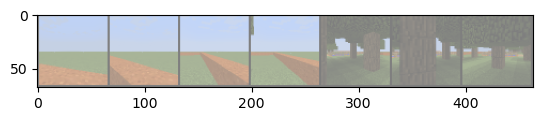

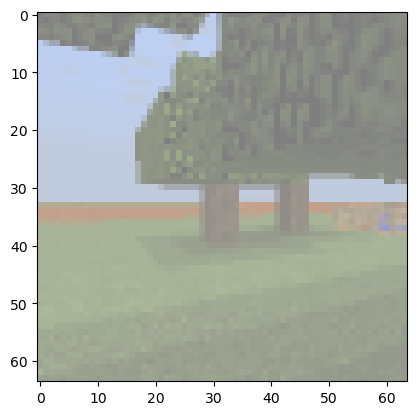

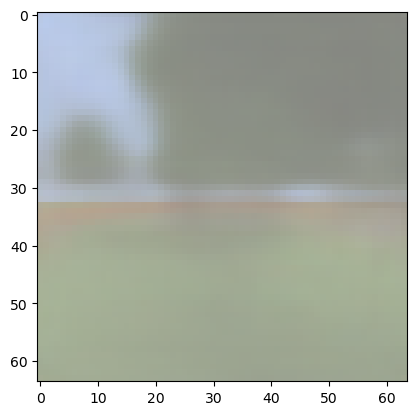

In [16]:
seq, corr = next(iter(test_loader))

imshow(torchvision.utils.make_grid(seq[0][0]))
imshow(corr[0])

with torch.no_grad():
    pred = model(seq[0].to(device), seq[1].to(device)).cpu() # won't this have issues with a batch norm or something if you have one batch

imshow(pred[0])